In [1]:
import glob
import xarray as xr
import matplotlib.pyplot as plt

In [2]:
def get_ClusterClient(
        ncores=1,
        nmem='25GB',
        walltime='01:00:00',
        account='UWAS0155'):
    """
    Code from Daniel Kennedy
    More info about Dask on HPC - https://ncar.github.io/dask-tutorial/notebooks/05-dask-hpc.html
    """
    from dask_jobqueue import PBSCluster
    from dask.distributed import Client

    cluster = PBSCluster(
        cores=ncores,              # The number of cores you want
        memory=nmem,               # Amount of memory
        processes=ncores,          # How many processes
        queue='casper',            # Queue name
        resource_spec='select=1:ncpus=' +\
        str(ncores)+':mem='+nmem,  # Specify resources
        account=account,           # Input your project ID here
        walltime=walltime,         # Amount of wall time
        interface='ext',           # Interface to use
    )

    client = Client(cluster)
    return cluster, client

In [8]:
# Create Dask cluster and client, scale up to 20 workers
cluster, client = get_ClusterClient(nmem="10GB")
cluster.scale(10)

In [3]:
## Check the status of the cluster
# client

## Prints the PBS job script that is used to submit the Dask workers
# print(cluster.job_script())

## Lists active workers and their status
# cluster.workers

## Lists current jobs in Casper queue
# !qstat -x -u $USER

In [ ]:
djk_basedir = "/glade/derecho/scratch/djk2120/archive/"
bgb_basedir = "/glade/derecho/scratch/bbuchovecky/archive"

cplhist = "cplhist"
cplhist_ext = "cplhist.ext"
default_dinit = "default.dinit"
coupPPE_hist_014_dinit = "coupPPE-hist.014.dinit"
coupPPE_hist_014_1880init = "coupPPE-hist.014.1880init"
coupPPE_hist_014_1880init_ext = "coupPPE-hist.014.1880init.ext"
coupPPE_hist_014_1950init = "coupPPE-hist.014.1950init"
coupPPE_hist_cplhist = "coupPPE-hist.cplhist"

djk_cases = [
    cplhist,
    cplhist_ext,
    default_dinit,
    coupPPE_hist_014_dinit,
    coupPPE_hist_014_1880init,
    coupPPE_hist_014_1880init_ext,
]

bgb_cases = [
    coupPPE_hist_014_1950init,
]

def _single_var(varname, case, basedir):
    def keep_var(ds):
        return ds[[varname]]
    
    data = xr.open_mfdataset(
            f"{basedir}/f.e21.FHIST_BGC.f09_f09.ersstv5.{case}/lnd/hist/f.e21.FHIST_BGC.f09_f09.ersstv5.{case}.clm2.h0.*.nc",
            combine="by_coords",
            parallel=True,
            preprocess=keep_var,
            chunks={"time": 60},
            engine="netcdf4",
        )[varname]

    new_time = xr.date_range(
    start=str(data.time[0].dt.year.item())+'-01',
    end=str(data.time[-1].dt.year.item()-1)+'-12',
    freq='MS', calendar='noleap', use_cftime=True)

    return data.assign_coords(time=new_time)


def get_single_var(varname):
    print(varname)
    data = dict()

    for case in djk_cases:
        print("  ", case)
        data[case] = _single_var(varname, case, djk_basedir)
    
    for case in bgb_cases:
        print("  ", case)
        data[case] = _single_var(varname, case, bgb_basedir)

    case = cplhist_ext
    area = xr.open_dataset(f"{djk_basedir}/f.e21.FHIST_BGC.f09_f09.ersstv5.{case}/lnd/hist/f.e21.FHIST_BGC.f09_f09.ersstv5.{case}.clm2.h0.2014-12.nc", decode_timedelta=False)["area"] * 1000000
    landfrac = xr.open_dataset(f"{djk_basedir}/f.e21.FHIST_BGC.f09_f09.ersstv5.{case}/lnd/hist/f.e21.FHIST_BGC.f09_f09.ersstv5.{case}.clm2.h0.2014-12.nc", decode_timedelta=False)["landfrac"]
    landarea = (area * landfrac).fillna(0)

    data[cplhist] = xr.concat([data[cplhist], data[cplhist_ext]], dim="time")
    data[coupPPE_hist_014_1880init] = xr.concat([data[coupPPE_hist_014_1880init], data[coupPPE_hist_014_1880init_ext]], dim="time")
    del data[cplhist_ext]
    del data[coupPPE_hist_014_1880init_ext]
    
    return data, landarea



tlai, landarea = get_single_var("TLAI")
# eflx, landarea = get_single_var("EFLX_LH_TOT")
totsomc, landarea = get_single_var("TOTSOMC")
totvegc, landarea = get_single_var("TOTVEGC")

TLAI
   cplhist
   cplhist.ext
   default.dinit
   coupPPE-hist.014.dinit
   coupPPE-hist.014.1880init
   coupPPE-hist.014.1880init.ext
   coupPPE-hist.014.1950init
TOTSOMC
   cplhist
   cplhist.ext
   default.dinit
   coupPPE-hist.014.dinit
   coupPPE-hist.014.1880init
   coupPPE-hist.014.1880init.ext
   coupPPE-hist.014.1950init
TOTVEGC
   cplhist
   cplhist.ext
   default.dinit
   coupPPE-hist.014.dinit
   coupPPE-hist.014.1880init
   coupPPE-hist.014.1880init.ext
   coupPPE-hist.014.1950init


In [11]:
goga_dir = "/glade/campaign/collections/rda/data/d651010/global/CESM2.1_GOGA_ERSSTv5"
goga_case = "f.e21.FHIST_BGC.f09_f09.historical.ersstv5.goga.ens"

tlai["goga"] = []
# eflx["goga"] = []
totsomc["goga"] = []
totvegc["goga"] = []

for i in range(10):
    for v, dalist in zip(["TLAI", "TOTSOMC", "TOTVEGC"], [tlai["goga"], totsomc["goga"], totvegc["goga"]]):
        goga_tmp = xr.open_mfdataset(f"{goga_dir}/lnd/proc/tseries/month_1/{v.upper()}/{goga_case}{str(i+1).zfill(2)}.clm2.h0.{v.upper()}.*.nc")[v.upper()]
        new_time = xr.date_range(
        start=str(goga_tmp.time[0].dt.year.item())+'-01',
        end=str(goga_tmp.time[-1].dt.year.item()-1)+'-12',
        freq='MS', calendar='noleap', use_cftime=True)
        dalist.append(goga_tmp.assign_coords(time=new_time))

In [ ]:
# cmip_dir = "/glade/campaign/collections/cmip/CMIP6/timeseries-cmip6"
# cmip_case = "f.e21.FHIST_BGC.f19_f19_mg17.CMIP6-AMIP-2deg"

# tlai["CMIP6-AMIP-2deg"] = []
# eflx["CMIP6-AMIP-2deg"] = []

# for i in range(3):
#     cmip_tmp = xr.open_mfdataset(f"{cmip_dir}/{cmip_case}.00{i+1}/lnd/proc/tseries/month_1/*h0*.TLAI.*.nc")["TLAI"]
#     new_time = xr.date_range(
#         start=str(cmip_tmp.time[0].dt.year.item())+'-01',
#         end=str(cmip_tmp.time[-1].dt.year.item()-1)+'-12',
#         freq='MS', calendar='noleap', use_cftime=True)
#     tlai["CMIP6-AMIP-2deg"].append(cmip_tmp.assign_coords(time=new_time))

#     cmip_tmp = xr.open_mfdataset(f"{cmip_dir}/{cmip_case}.00{i+1}/lnd/proc/tseries/month_1/*h0*.EFLX_LH_TOT.*.nc")["EFLX_LH_TOT"]
#     new_time = xr.date_range(
#         start=str(cmip_tmp.time[0].dt.year.item())+'-01',
#         end=str(cmip_tmp.time[-1].dt.year.item()-1)+'-12',
#         freq='MS', calendar='noleap', use_cftime=True)
#     eflx["CMIP6-AMIP-2deg"].append(cmip_tmp.assign_coords(time=new_time))

# cmip_tmp = xr.open_mfdataset(f"{cmip_dir}/{cmip_case}.001/lnd/proc/tseries/month_1/{cmip_case}.001.clm2.h0.TLAI.*.nc").isel(time=0)
# cmip_landarea = (cmip_tmp["area"] * cmip_tmp["landfrac"]).fillna(0)

In [ ]:
# case = "CMIP6-AMIP-2deg-3year-srcmod"
# tlai[case] = xr.open_dataset(f"/glade/derecho/scratch/bbuchovecky/archive/f.e21.FHIST_BGC.f19_f19_mg17.{case}/lnd/hist/f.e21.FHIST_BGC.f19_f19_mg17.{case}.clm2.h0.1950-02-01-00000.nc", decode_timedelta=False)["TLAI"]
# eflx[case] = xr.open_dataset(f"/glade/derecho/scratch/bbuchovecky/archive/f.e21.FHIST_BGC.f19_f19_mg17.{case}/lnd/hist/f.e21.FHIST_BGC.f19_f19_mg17.{case}.clm2.h0.1950-02-01-00000.nc", decode_timedelta=False)["EFLX_LH_TOT"]
# new_time = xr.date_range(
#     start=str(tlai[case].time[0].dt.year.item())+'-01',
#     end=str(tlai[case].time[-1].dt.year.item()-1)+'-12',
#     freq='MS', calendar='noleap', use_cftime=True)
# tlai[case] = tlai[case].assign_coords(time=new_time)
# eflx[case] = eflx[case].assign_coords(time=new_time)

# case = "coupPPE-hist.000"
# tlai[case] = xr.open_dataset(f"/glade/derecho/scratch/bbuchovecky/archive/f.e22.FHIST_BGC.f19_f17_mg17.{case}/lnd/proc/tseries/month_1/f.e22.FHIST_BGC.f19_f17_mg17.{case}.clm2.h0.TLAI.195001-201412.nc", decode_timedelta=False)["TLAI"]
# eflx[case] = xr.open_dataset(f"/glade/derecho/scratch/bbuchovecky/archive/f.e22.FHIST_BGC.f19_f17_mg17.{case}/lnd/proc/tseries/month_1/f.e22.FHIST_BGC.f19_f17_mg17.{case}.clm2.h0.EFLX_LH_TOT.195001-201412.nc", decode_timedelta=False)["EFLX_LH_TOT"]
# new_time = xr.date_range(
#     start=str(tlai[case].time[0].dt.year.item())+'-01',
#     end=str(tlai[case].time[-1].dt.year.item()-1)+'-12',
#     freq='MS', calendar='noleap', use_cftime=True)
# tlai[case] = tlai[case].assign_coords(time=new_time)
# eflx[case] = eflx[case].assign_coords(time=new_time)

# deg2_area = xr.open_dataset(f"/glade/derecho/scratch/bbuchovecky/archive/f.e22.FHIST_BGC.f19_f17_mg17.{case}/lnd/proc/tseries/month_1/f.e22.FHIST_BGC.f19_f17_mg17.{case}.clm2.h0.TLAI.195001-201412.nc", decode_timedelta=False)["area"]
# deg2_landfrac = xr.open_dataset(f"/glade/derecho/scratch/bbuchovecky/archive/f.e22.FHIST_BGC.f19_f17_mg17.{case}/lnd/proc/tseries/month_1/f.e22.FHIST_BGC.f19_f17_mg17.{case}.clm2.h0.EFLX_LH_TOT.195001-201412.nc", decode_timedelta=False)["landfrac"]
# deg2_landarea =  (deg2_area * deg2_landfrac).fillna(0)

(np.float64(0.0), np.float64(1.0), np.float64(0.0), np.float64(1.0))

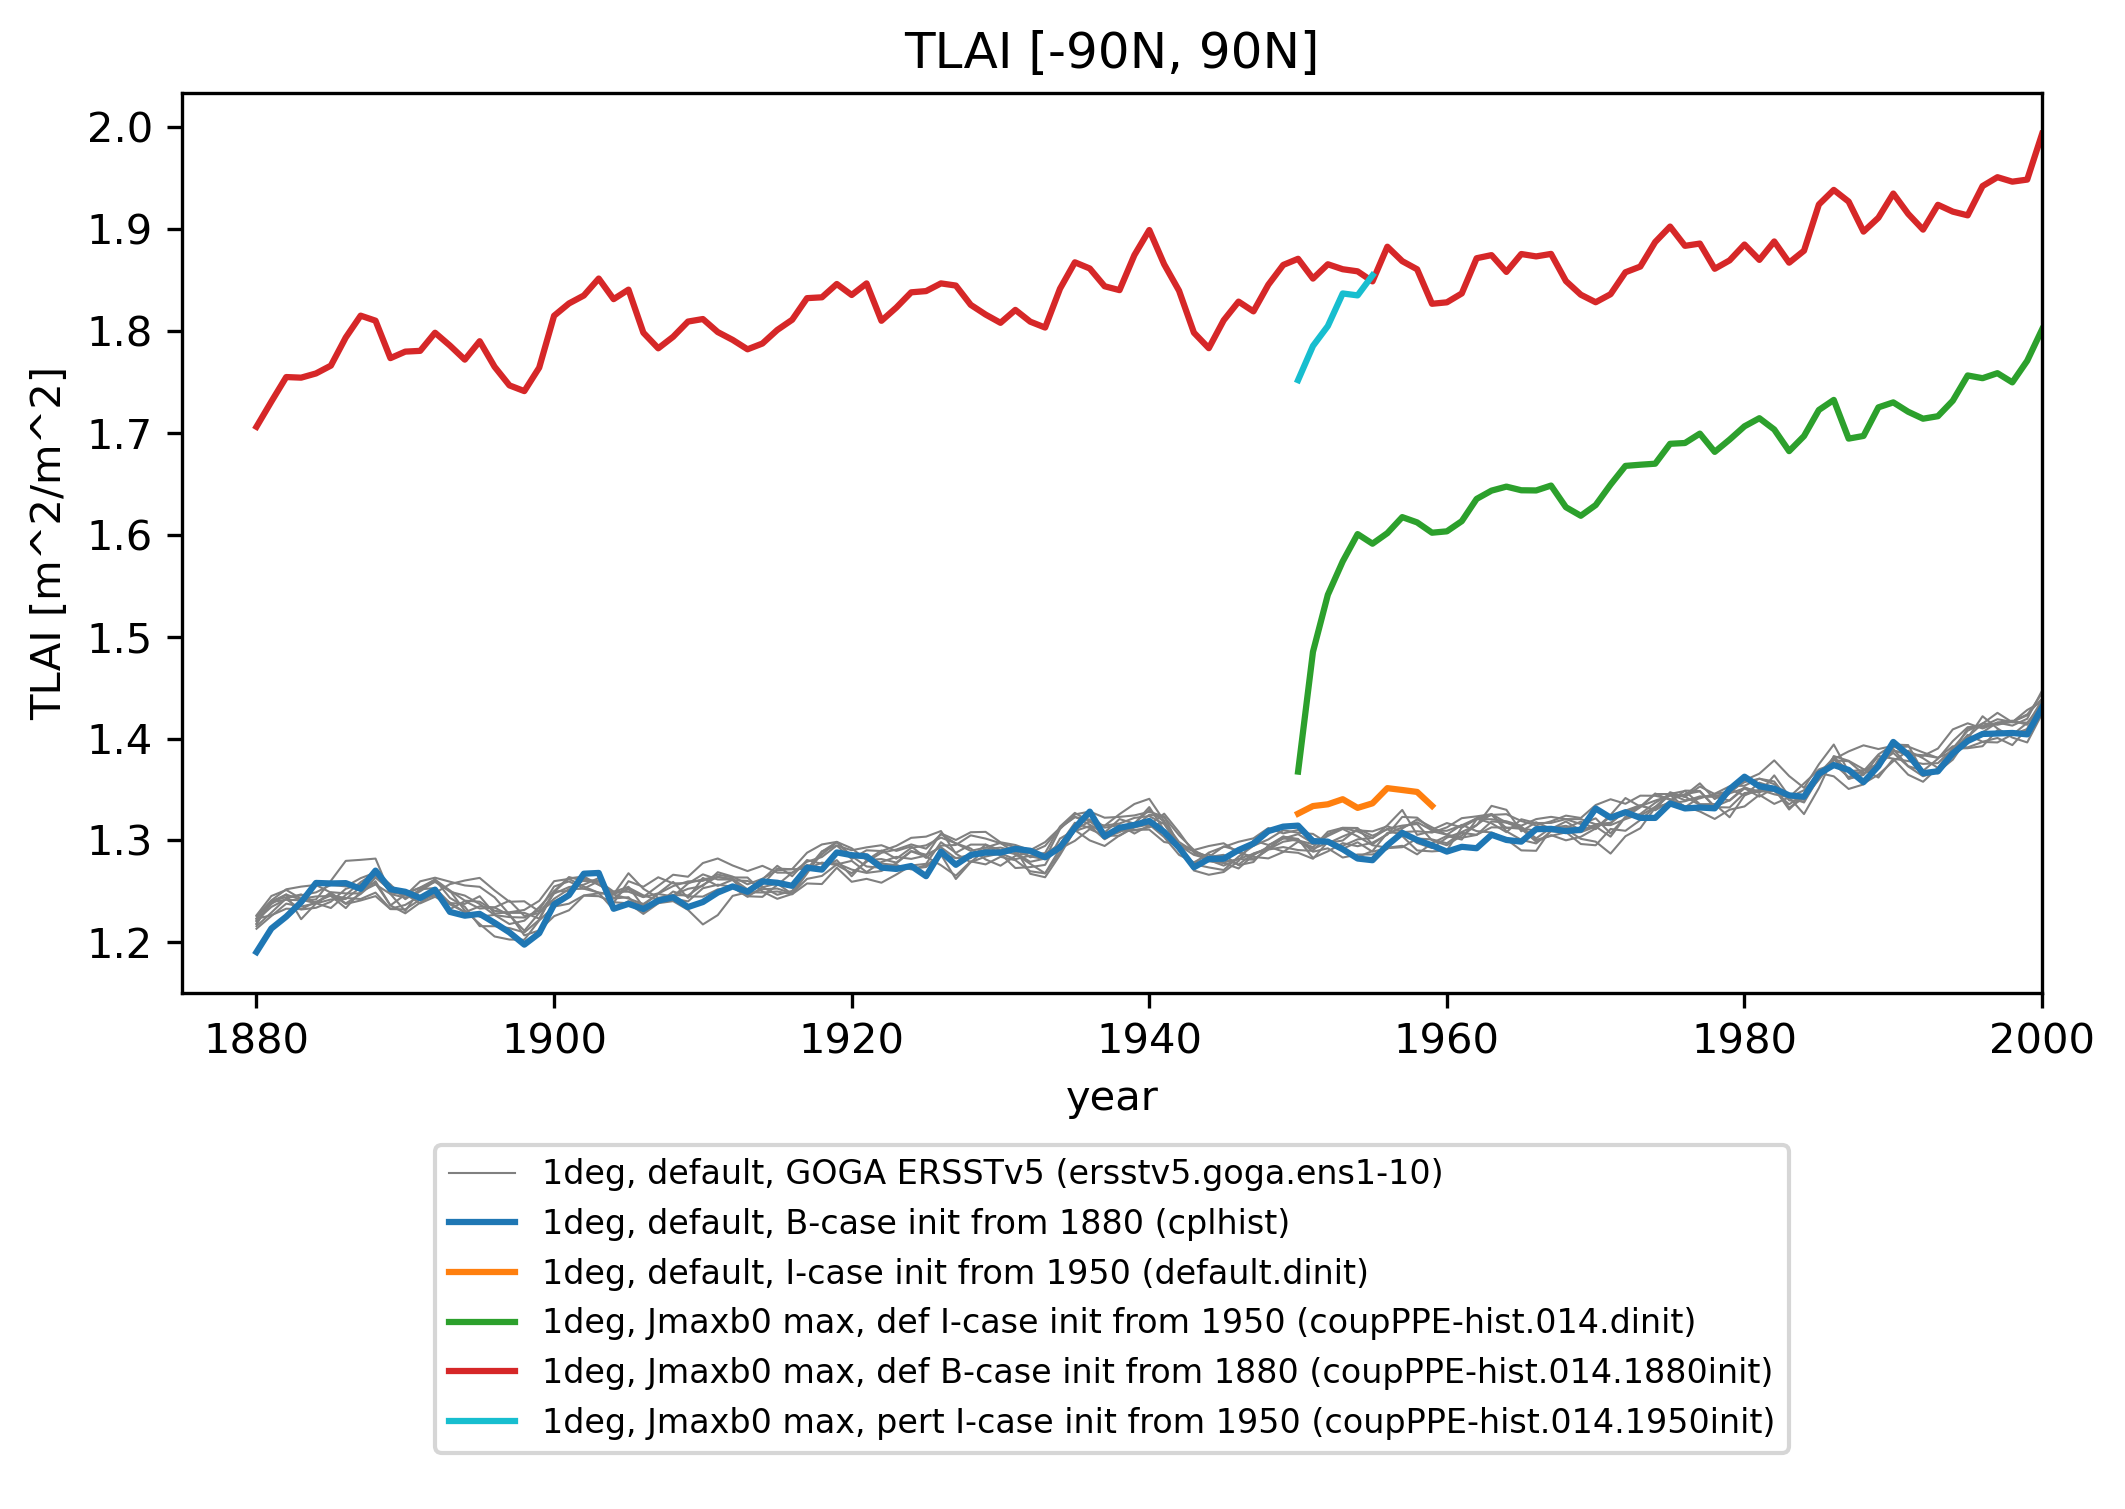

In [12]:
fig, ax = plt.subplots(2, 1, height_ratios=[1, 0.4], figsize=(8, 6), dpi=300)
srtyr = 1875
endyr = 2000

lat_1 = -90
lat_2 = 90

for i in range(10):
    label = None
    if i == 0:
        label = "1deg, default, GOGA ERSSTv5 (ersstv5.goga.ens1-10)"
    tlai["goga"][i].sel(lat=slice(lat_1, lat_2), time=slice(f"{srtyr}-01", f"{endyr}-12")).weighted(landarea).mean(dim=["lat", "lon"]).groupby("time.year").mean(dim="time").plot(ax=ax[0], color="gray", linestyle="-", lw=0.5, label=label)

tlai["cplhist"].sel(lat=slice(lat_1, lat_2), time=slice(f"{srtyr}-01", f"{endyr}-12")).weighted(landarea).mean(dim=["lat", "lon"]).groupby("time.year").mean(dim="time").plot(ax=ax[0], color="tab:blue", linestyle="-", label="1deg, default, B-case init from 1880 (cplhist)")
tlai["default.dinit"].sel(lat=slice(lat_1, lat_2), time=slice(f"{srtyr}-01", f"{endyr}-12")).weighted(landarea).mean(dim=["lat", "lon"]).groupby("time.year").mean(dim="time").plot(ax=ax[0], color="tab:orange", linestyle="-", label="1deg, default, I-case init from 1950 (default.dinit)")

tlai["coupPPE-hist.014.dinit"].sel(lat=slice(lat_1, lat_2), time=slice(f"{srtyr}-01", f"{endyr}-12")).weighted(landarea).mean(dim=["lat", "lon"]).groupby("time.year").mean(dim="time").plot(ax=ax[0], color="tab:green", linestyle="-", label="1deg, Jmaxb0 max, def I-case init from 1950 (coupPPE-hist.014.dinit)")
tlai["coupPPE-hist.014.1880init"].sel(lat=slice(lat_1, lat_2), time=slice(f"{srtyr}-01", f"{endyr}-12")).weighted(landarea).mean(dim=["lat", "lon"]).groupby("time.year").mean(dim="time").plot(ax=ax[0], color="tab:red", linestyle="-", label="1deg, Jmaxb0 max, def B-case init from 1880 (coupPPE-hist.014.1880init)")
tlai["coupPPE-hist.014.1950init"].sel(lat=slice(lat_1, lat_2), time=slice(f"{srtyr}-01", f"{endyr}-12")).weighted(landarea).mean(dim=["lat", "lon"]).groupby("time.year").mean(dim="time").plot(ax=ax[0], color="tab:cyan", linestyle="-", label="1deg, Jmaxb0 max, pert I-case init from 1950 (coupPPE-hist.014.1950init)")

ax[0].set_xlim(srtyr, endyr)
ax[0].set_ylabel("TLAI [m^2/m^2]")
ax[0].set_title(f"TLAI [{lat_1}N, {lat_2}N]")

h, l = ax[0].get_legend_handles_labels()
leg = ax[1].legend(h, l, fontsize=8, loc='center')
ax[1].axis('off')

(np.float64(0.0), np.float64(1.0), np.float64(0.0), np.float64(1.0))

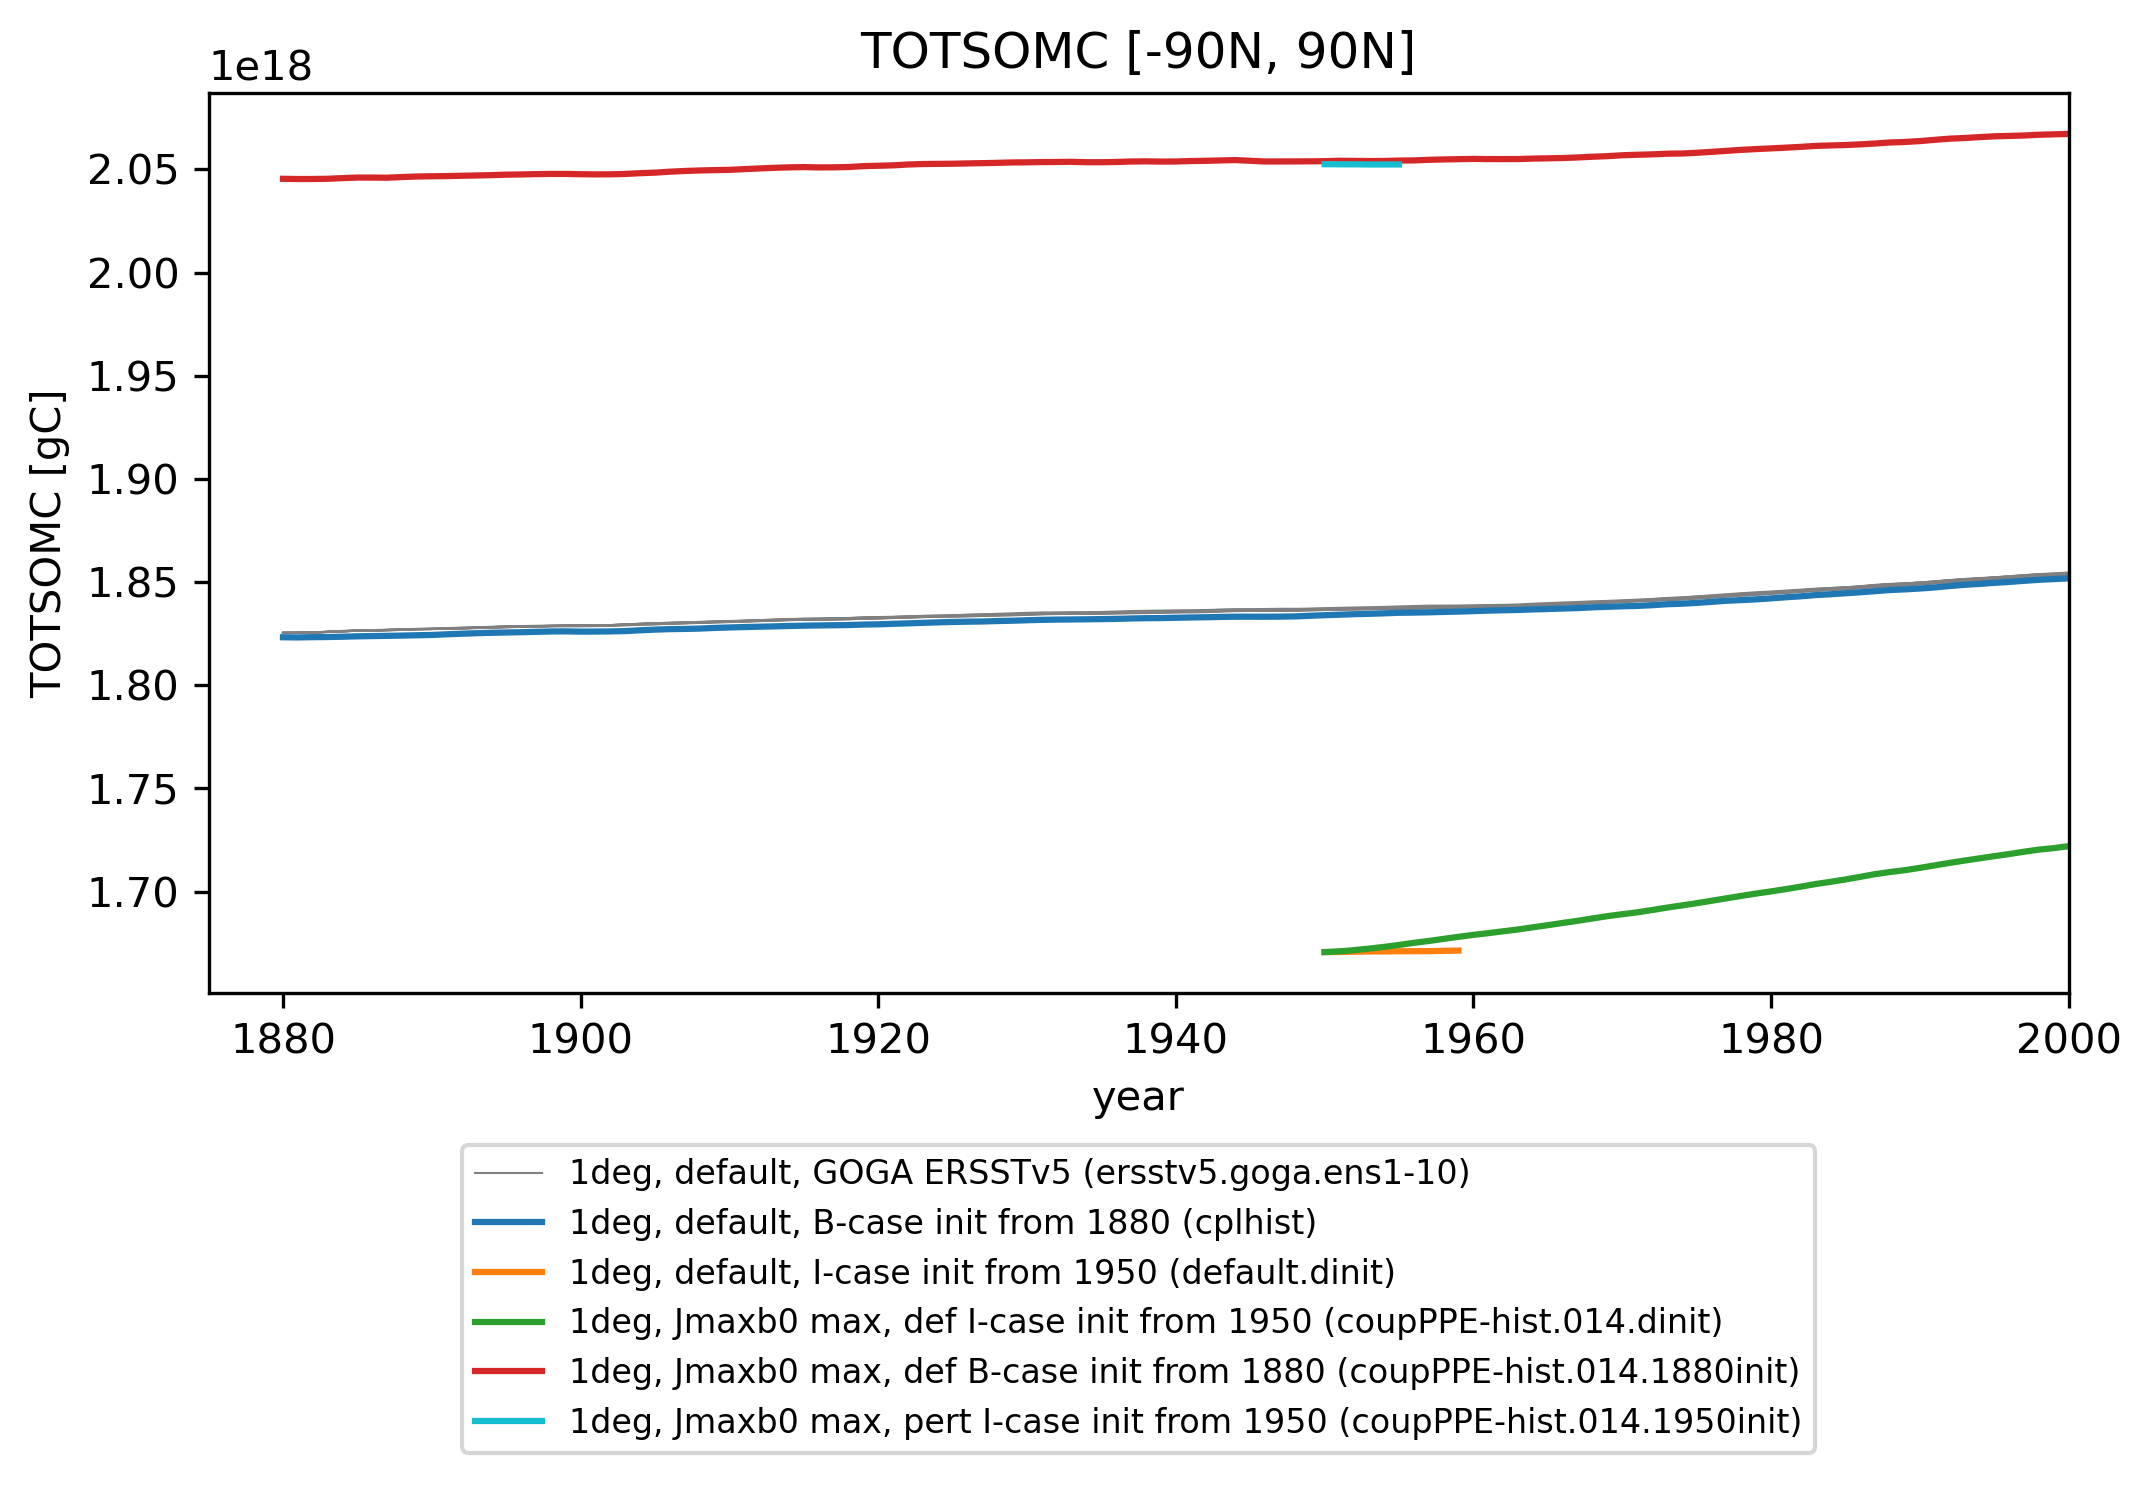

In [13]:
fig, ax = plt.subplots(2, 1, height_ratios=[1, 0.4], figsize=(8, 6), dpi=300)
srtyr = 1875
endyr = 2000

lat_1 = -90
lat_2 = 90

for i in range(10):
    label = None
    if i == 0:
        label = "1deg, default, GOGA ERSSTv5 (ersstv5.goga.ens1-10)"
    (totsomc["goga"][i].sel(lat=slice(lat_1, lat_2), time=slice(f"{srtyr}-01", f"{endyr}-12")) * landarea).sum(dim=["lat", "lon"]).groupby("time.year").mean(dim="time").plot(ax=ax[0], color="gray", linestyle="-", lw=0.5, label=label)

(totsomc["cplhist"].sel(lat=slice(lat_1, lat_2), time=slice(f"{srtyr}-01", f"{endyr}-12")) * landarea).sum(dim=["lat", "lon"]).groupby("time.year").mean(dim="time").plot(ax=ax[0], color="tab:blue", linestyle="-", label="1deg, default, B-case init from 1880 (cplhist)")
(totsomc["default.dinit"].sel(lat=slice(lat_1, lat_2), time=slice(f"{srtyr}-01", f"{endyr}-12")) * landarea).sum(dim=["lat", "lon"]).groupby("time.year").mean(dim="time").plot(ax=ax[0], color="tab:orange", linestyle="-", label="1deg, default, I-case init from 1950 (default.dinit)")

(totsomc["coupPPE-hist.014.dinit"].sel(lat=slice(lat_1, lat_2), time=slice(f"{srtyr}-01", f"{endyr}-12")) * landarea).sum(dim=["lat", "lon"]).groupby("time.year").mean(dim="time").plot(ax=ax[0], color="tab:green", linestyle="-", label="1deg, Jmaxb0 max, def I-case init from 1950 (coupPPE-hist.014.dinit)")
(totsomc["coupPPE-hist.014.1880init"].sel(lat=slice(lat_1, lat_2), time=slice(f"{srtyr}-01", f"{endyr}-12")) * landarea).sum(dim=["lat", "lon"]).groupby("time.year").mean(dim="time").plot(ax=ax[0], color="tab:red", linestyle="-", label="1deg, Jmaxb0 max, def B-case init from 1880 (coupPPE-hist.014.1880init)")
(totsomc["coupPPE-hist.014.1950init"].sel(lat=slice(lat_1, lat_2), time=slice(f"{srtyr}-01", f"{endyr}-12")) * landarea).sum(dim=["lat", "lon"]).groupby("time.year").mean(dim="time").plot(ax=ax[0], color="tab:cyan", linestyle="-", label="1deg, Jmaxb0 max, pert I-case init from 1950 (coupPPE-hist.014.1950init)")

ax[0].set_xlim(srtyr, endyr)
ax[0].set_ylabel("TOTSOMC [gC]")
ax[0].set_title(f"TOTSOMC [{lat_1}N, {lat_2}N]")

h, l = ax[0].get_legend_handles_labels()
leg = ax[1].legend(h, l, fontsize=8, loc='center')
ax[1].axis('off')

(np.float64(0.0), np.float64(1.0), np.float64(0.0), np.float64(1.0))

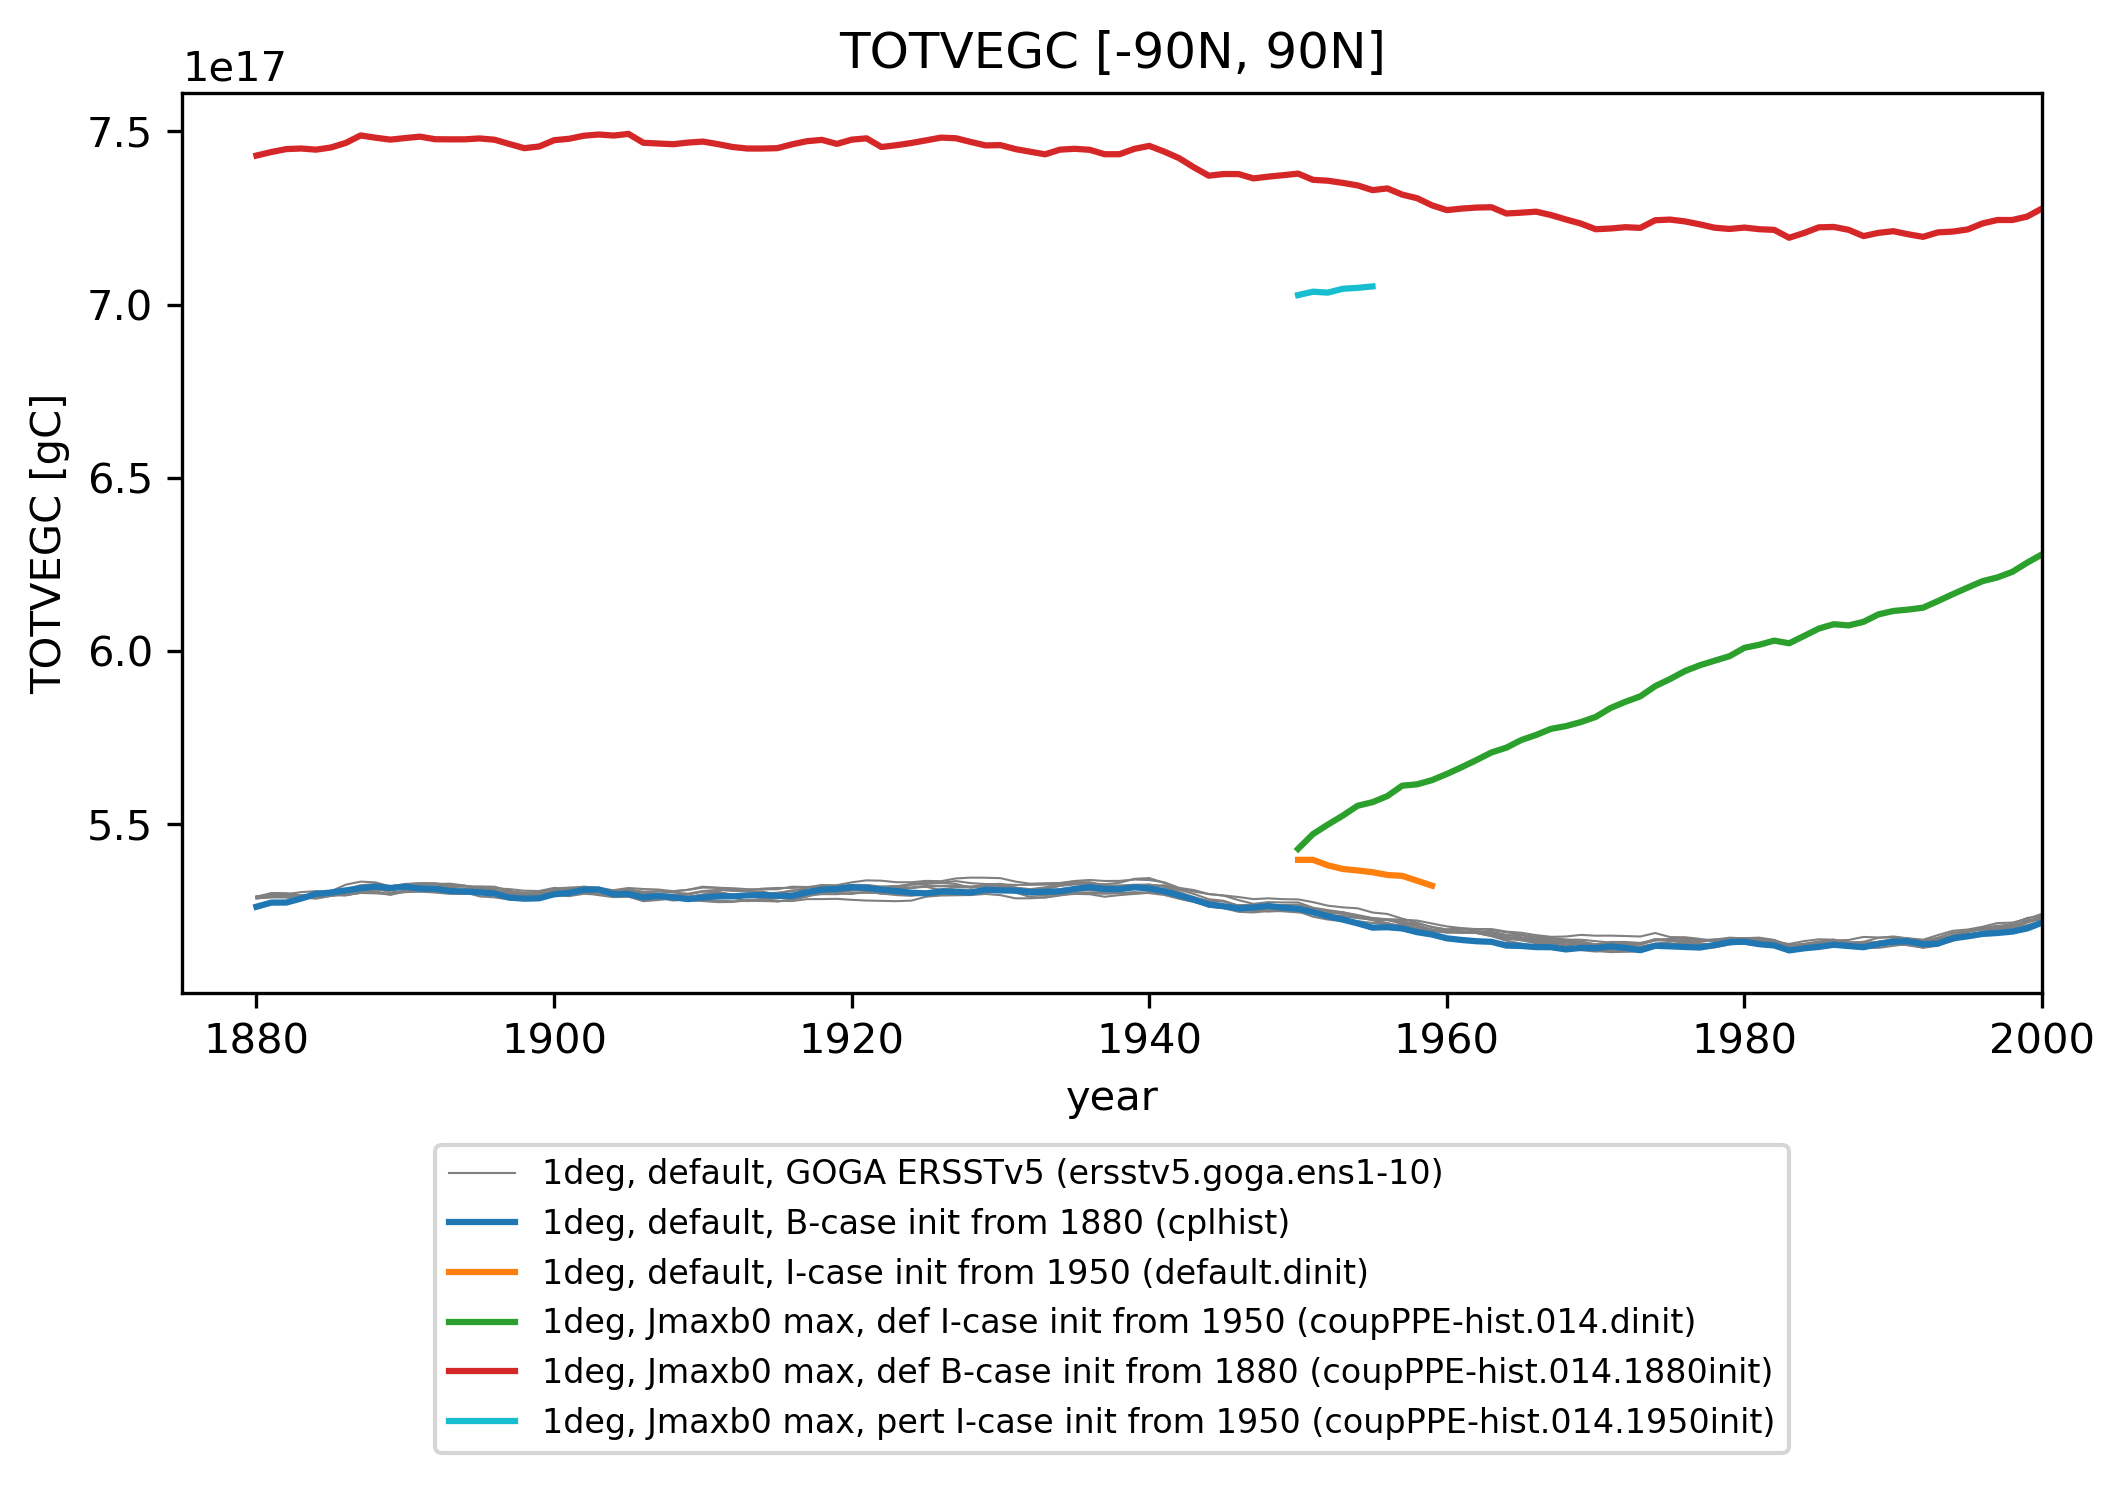

In [14]:
fig, ax = plt.subplots(2, 1, height_ratios=[1, 0.4], figsize=(8, 6), dpi=300)
srtyr = 1875
endyr = 2000

lat_1 = -90
lat_2 = 90

for i in range(10):
    label = None
    if i == 0:
        label = "1deg, default, GOGA ERSSTv5 (ersstv5.goga.ens1-10)"
    (totvegc["goga"][i].sel(lat=slice(lat_1, lat_2), time=slice(f"{srtyr}-01", f"{endyr}-12")) * landarea).sum(dim=["lat", "lon"]).groupby("time.year").mean(dim="time").plot(ax=ax[0], color="gray", linestyle="-", lw=0.5, label=label)

(totvegc["cplhist"].sel(lat=slice(lat_1, lat_2), time=slice(f"{srtyr}-01", f"{endyr}-12")) * landarea).sum(dim=["lat", "lon"]).groupby("time.year").mean(dim="time").plot(ax=ax[0], color="tab:blue", linestyle="-", label="1deg, default, B-case init from 1880 (cplhist)")
(totvegc["default.dinit"].sel(lat=slice(lat_1, lat_2), time=slice(f"{srtyr}-01", f"{endyr}-12")) * landarea).sum(dim=["lat", "lon"]).groupby("time.year").mean(dim="time").plot(ax=ax[0], color="tab:orange", linestyle="-", label="1deg, default, I-case init from 1950 (default.dinit)")

(totvegc["coupPPE-hist.014.dinit"].sel(lat=slice(lat_1, lat_2), time=slice(f"{srtyr}-01", f"{endyr}-12")) * landarea).sum(dim=["lat", "lon"]).groupby("time.year").mean(dim="time").plot(ax=ax[0], color="tab:green", linestyle="-", label="1deg, Jmaxb0 max, def I-case init from 1950 (coupPPE-hist.014.dinit)")
(totvegc["coupPPE-hist.014.1880init"].sel(lat=slice(lat_1, lat_2), time=slice(f"{srtyr}-01", f"{endyr}-12")) * landarea).sum(dim=["lat", "lon"]).groupby("time.year").mean(dim="time").plot(ax=ax[0], color="tab:red", linestyle="-", label="1deg, Jmaxb0 max, def B-case init from 1880 (coupPPE-hist.014.1880init)")
(totvegc["coupPPE-hist.014.1950init"].sel(lat=slice(lat_1, lat_2), time=slice(f"{srtyr}-01", f"{endyr}-12")) * landarea).sum(dim=["lat", "lon"]).groupby("time.year").mean(dim="time").plot(ax=ax[0], color="tab:cyan", linestyle="-", label="1deg, Jmaxb0 max, pert I-case init from 1950 (coupPPE-hist.014.1950init)")

ax[0].set_xlim(srtyr, endyr)
ax[0].set_ylabel("TOTVEGC [gC]")
ax[0].set_title(f"TOTVEGC [{lat_1}N, {lat_2}N]")

h, l = ax[0].get_legend_handles_labels()
leg = ax[1].legend(h, l, fontsize=8, loc='center')
ax[1].axis('off')

---

(0.0, 1.0, 0.0, 1.0)

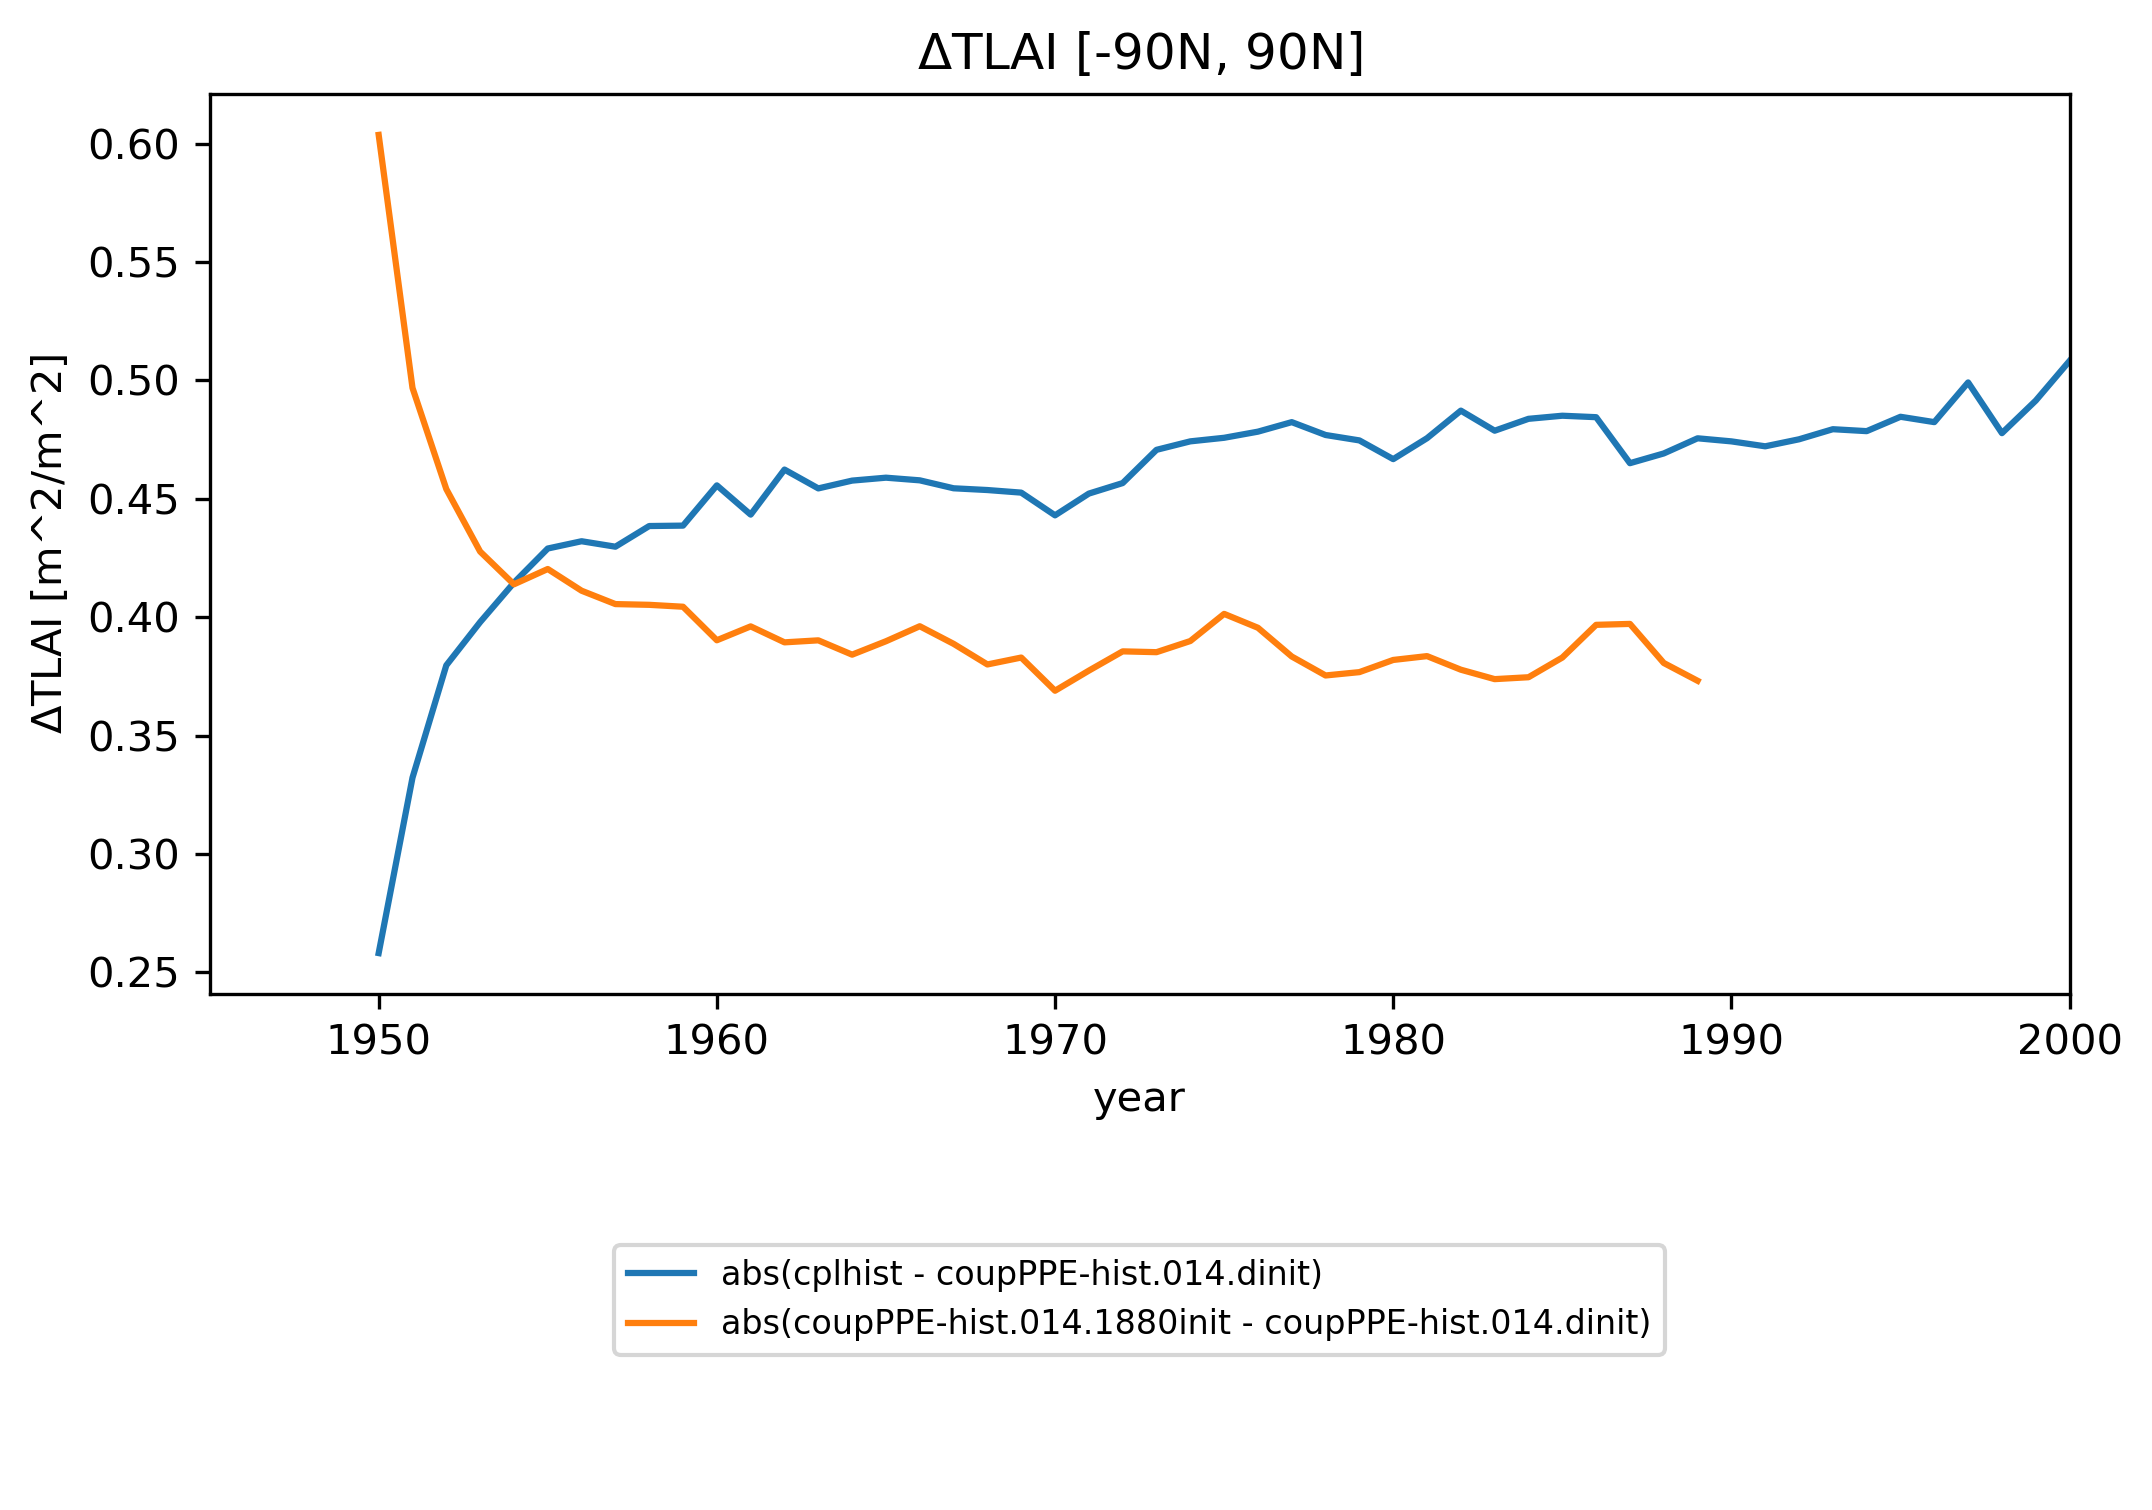

In [16]:
fig, ax = plt.subplots(2, 1, height_ratios=[1, 0.4], figsize=(8, 6), dpi=300)
srtyr = 1945
endyr = 2000

lat_1 = -90
lat_2 = 90

delta_a_b = abs(tlai["cplhist"].sel(lat=slice(lat_1, lat_2), time=slice(f"{srtyr}-01", f"{endyr}-12")) - tlai["coupPPE-hist.014.dinit"].sel(lat=slice(lat_1, lat_2), time=slice(f"{srtyr}-01", f"{endyr}-12"))).weighted(landarea).mean(dim=["lat", "lon"]).groupby("time.year").mean(dim="time").plot(ax=ax[0], color="tab:blue", label="abs(cplhist - coupPPE-hist.014.dinit)")
delta_b_c = abs(tlai["coupPPE-hist.014.1880init"].sel(lat=slice(lat_1, lat_2), time=slice(f"{srtyr}-01", f"{endyr}-12")) - tlai["coupPPE-hist.014.dinit"].sel(lat=slice(lat_1, lat_2), time=slice(f"{srtyr}-01", f"{endyr}-12"))).weighted(landarea).mean(dim=["lat", "lon"]).groupby("time.year").mean(dim="time").plot(ax=ax[0], color="tab:orange", label="abs(coupPPE-hist.014.1880init - coupPPE-hist.014.dinit)")

ax[0].set_xlim(srtyr, endyr)
ax[0].set_ylabel("$\\Delta$TLAI [m^2/m^2]")
ax[0].set_title(f"$\\Delta$TLAI [{lat_1}N, {lat_2}N]")

h, l = ax[0].get_legend_handles_labels()
leg = ax[1].legend(h, l, fontsize=8, loc='center')
ax[1].axis('off')

(0.0, 1.0, 0.0, 1.0)

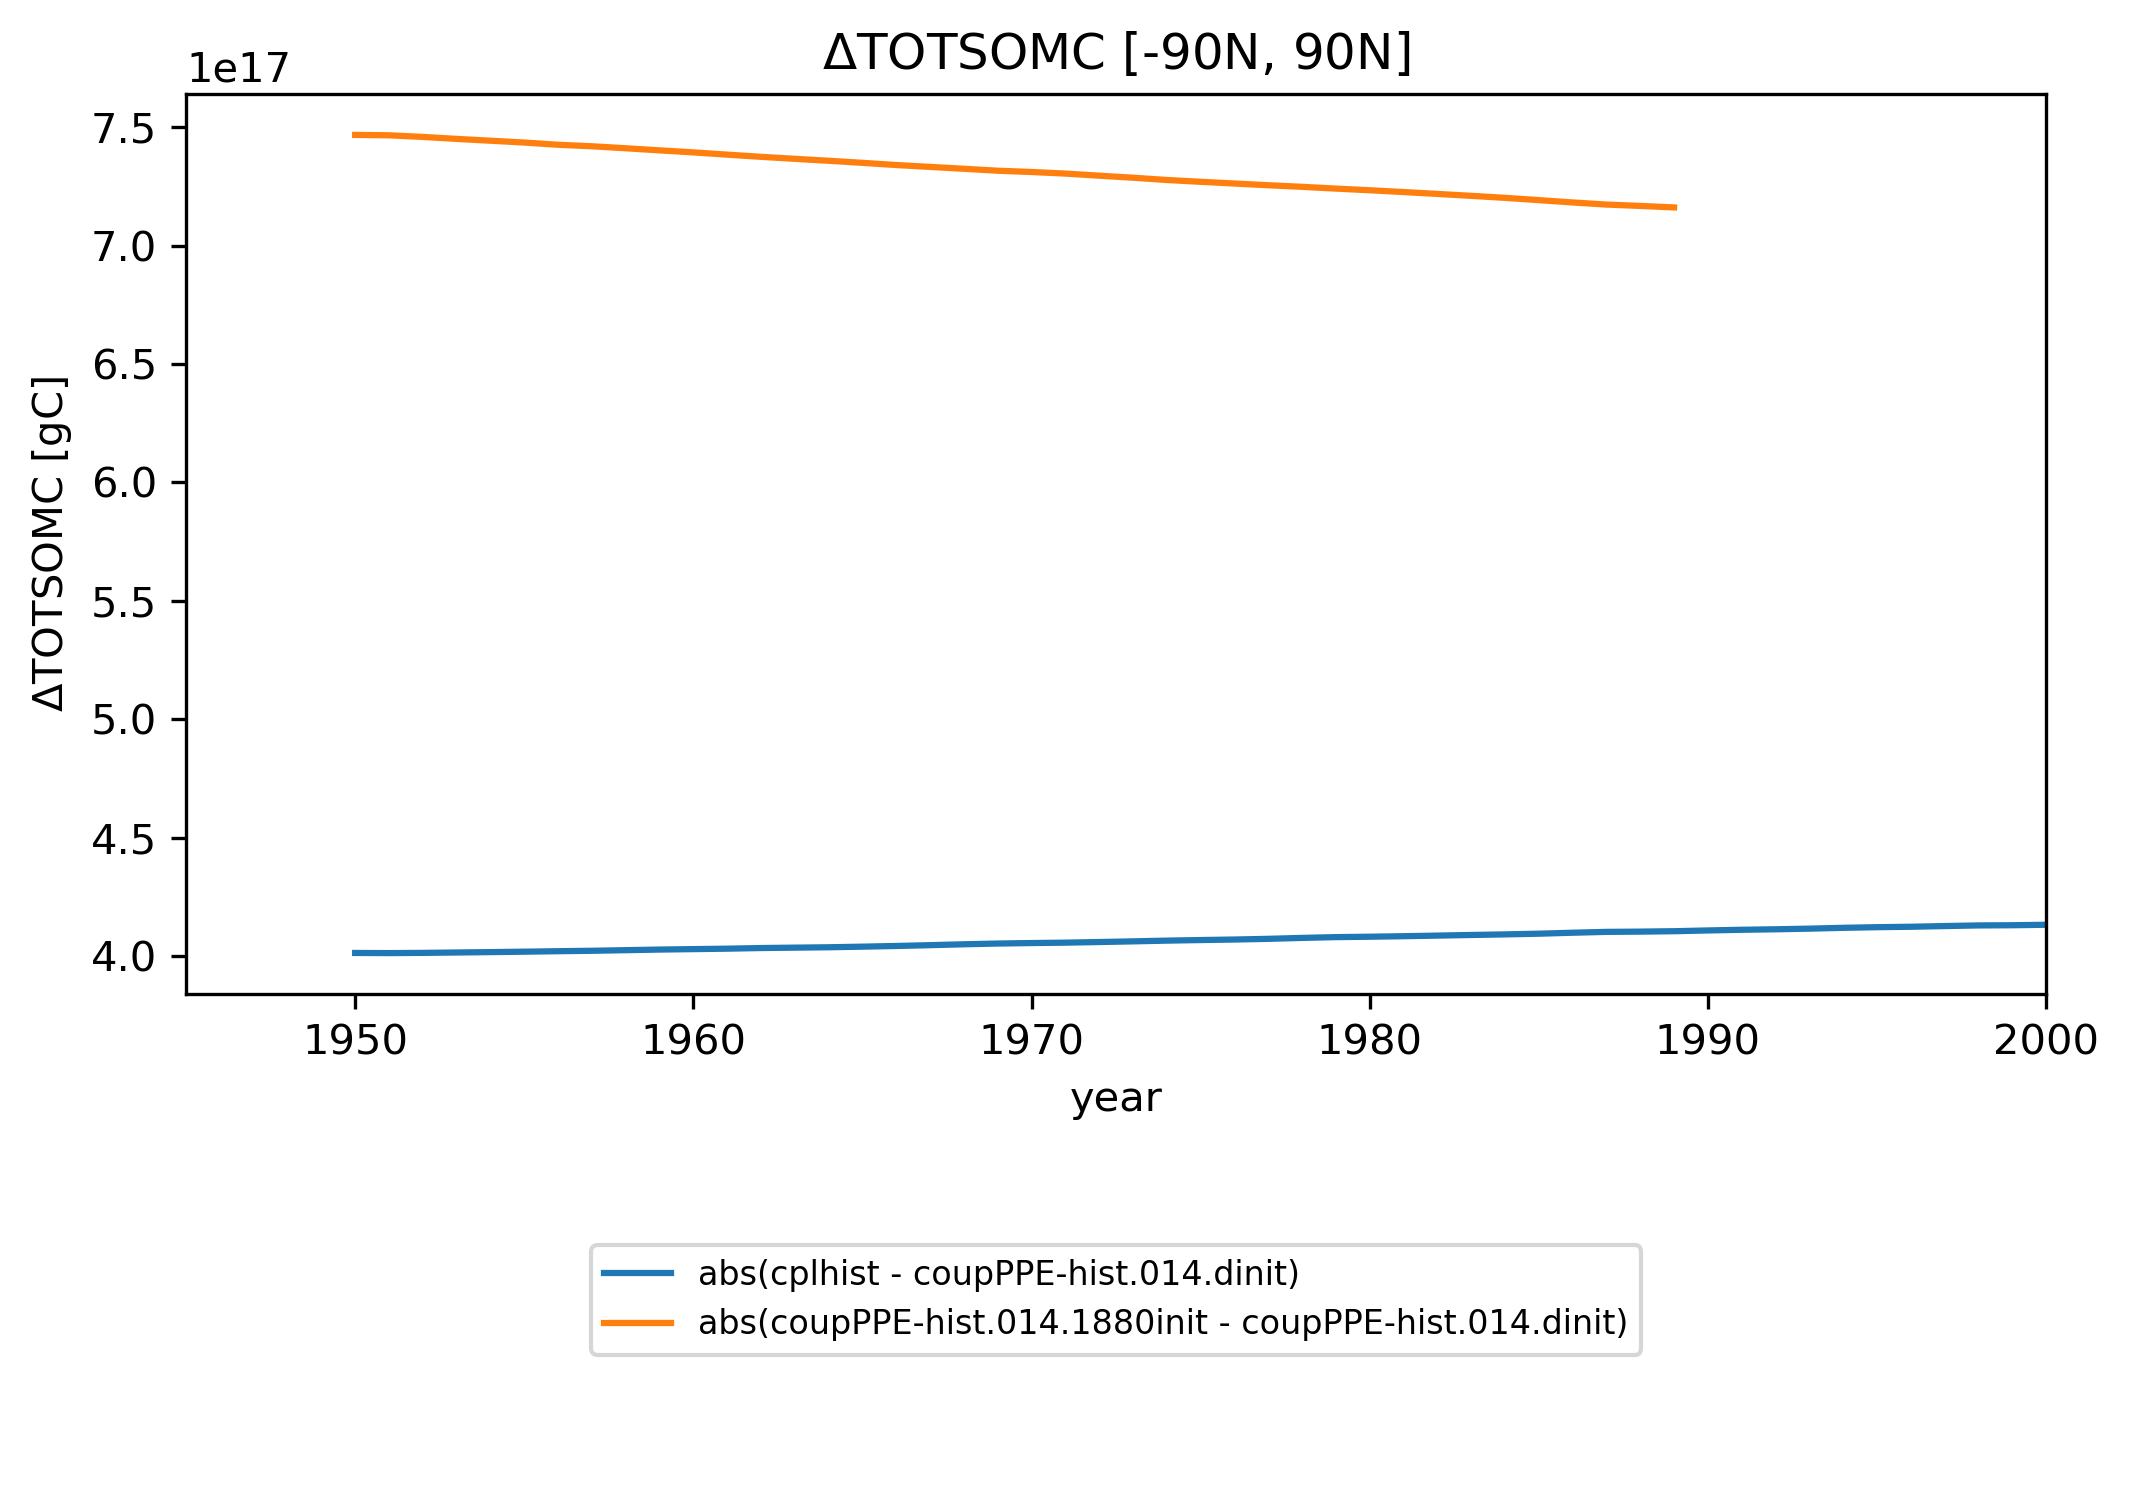

In [28]:
fig, ax = plt.subplots(2, 1, height_ratios=[1, 0.4], figsize=(8, 6), dpi=300)
srtyr = 1945
endyr = 2000

lat_1 = -90
lat_2 = 90

delta_a_b = (abs(totsomc["cplhist"].sel(lat=slice(lat_1, lat_2), time=slice(f"{srtyr}-01", f"{endyr}-12")) - totsomc["coupPPE-hist.014.dinit"].sel(lat=slice(lat_1, lat_2), time=slice(f"{srtyr}-01", f"{endyr}-12"))) * landarea).sum(dim=["lat", "lon"]).groupby("time.year").mean(dim="time").plot(ax=ax[0], color="tab:blue", label="abs(cplhist - coupPPE-hist.014.dinit)")
delta_b_c = (abs(totsomc["coupPPE-hist.014.1880init"].sel(lat=slice(lat_1, lat_2), time=slice(f"{srtyr}-01", f"{endyr}-12")) - totsomc["coupPPE-hist.014.dinit"].sel(lat=slice(lat_1, lat_2), time=slice(f"{srtyr}-01", f"{endyr}-12"))) * landarea).sum(dim=["lat", "lon"]).groupby("time.year").mean(dim="time").plot(ax=ax[0], color="tab:orange", label="abs(coupPPE-hist.014.1880init - coupPPE-hist.014.dinit)")

ax[0].set_xlim(srtyr, endyr)
ax[0].set_ylabel("$\\Delta$TOTSOMC [gC]")
ax[0].set_title(f"$\\Delta$TOTSOMC [{lat_1}N, {lat_2}N]")

h, l = ax[0].get_legend_handles_labels()
leg = ax[1].legend(h, l, fontsize=8, loc='center')
ax[1].axis('off')

(0.0, 1.0, 0.0, 1.0)

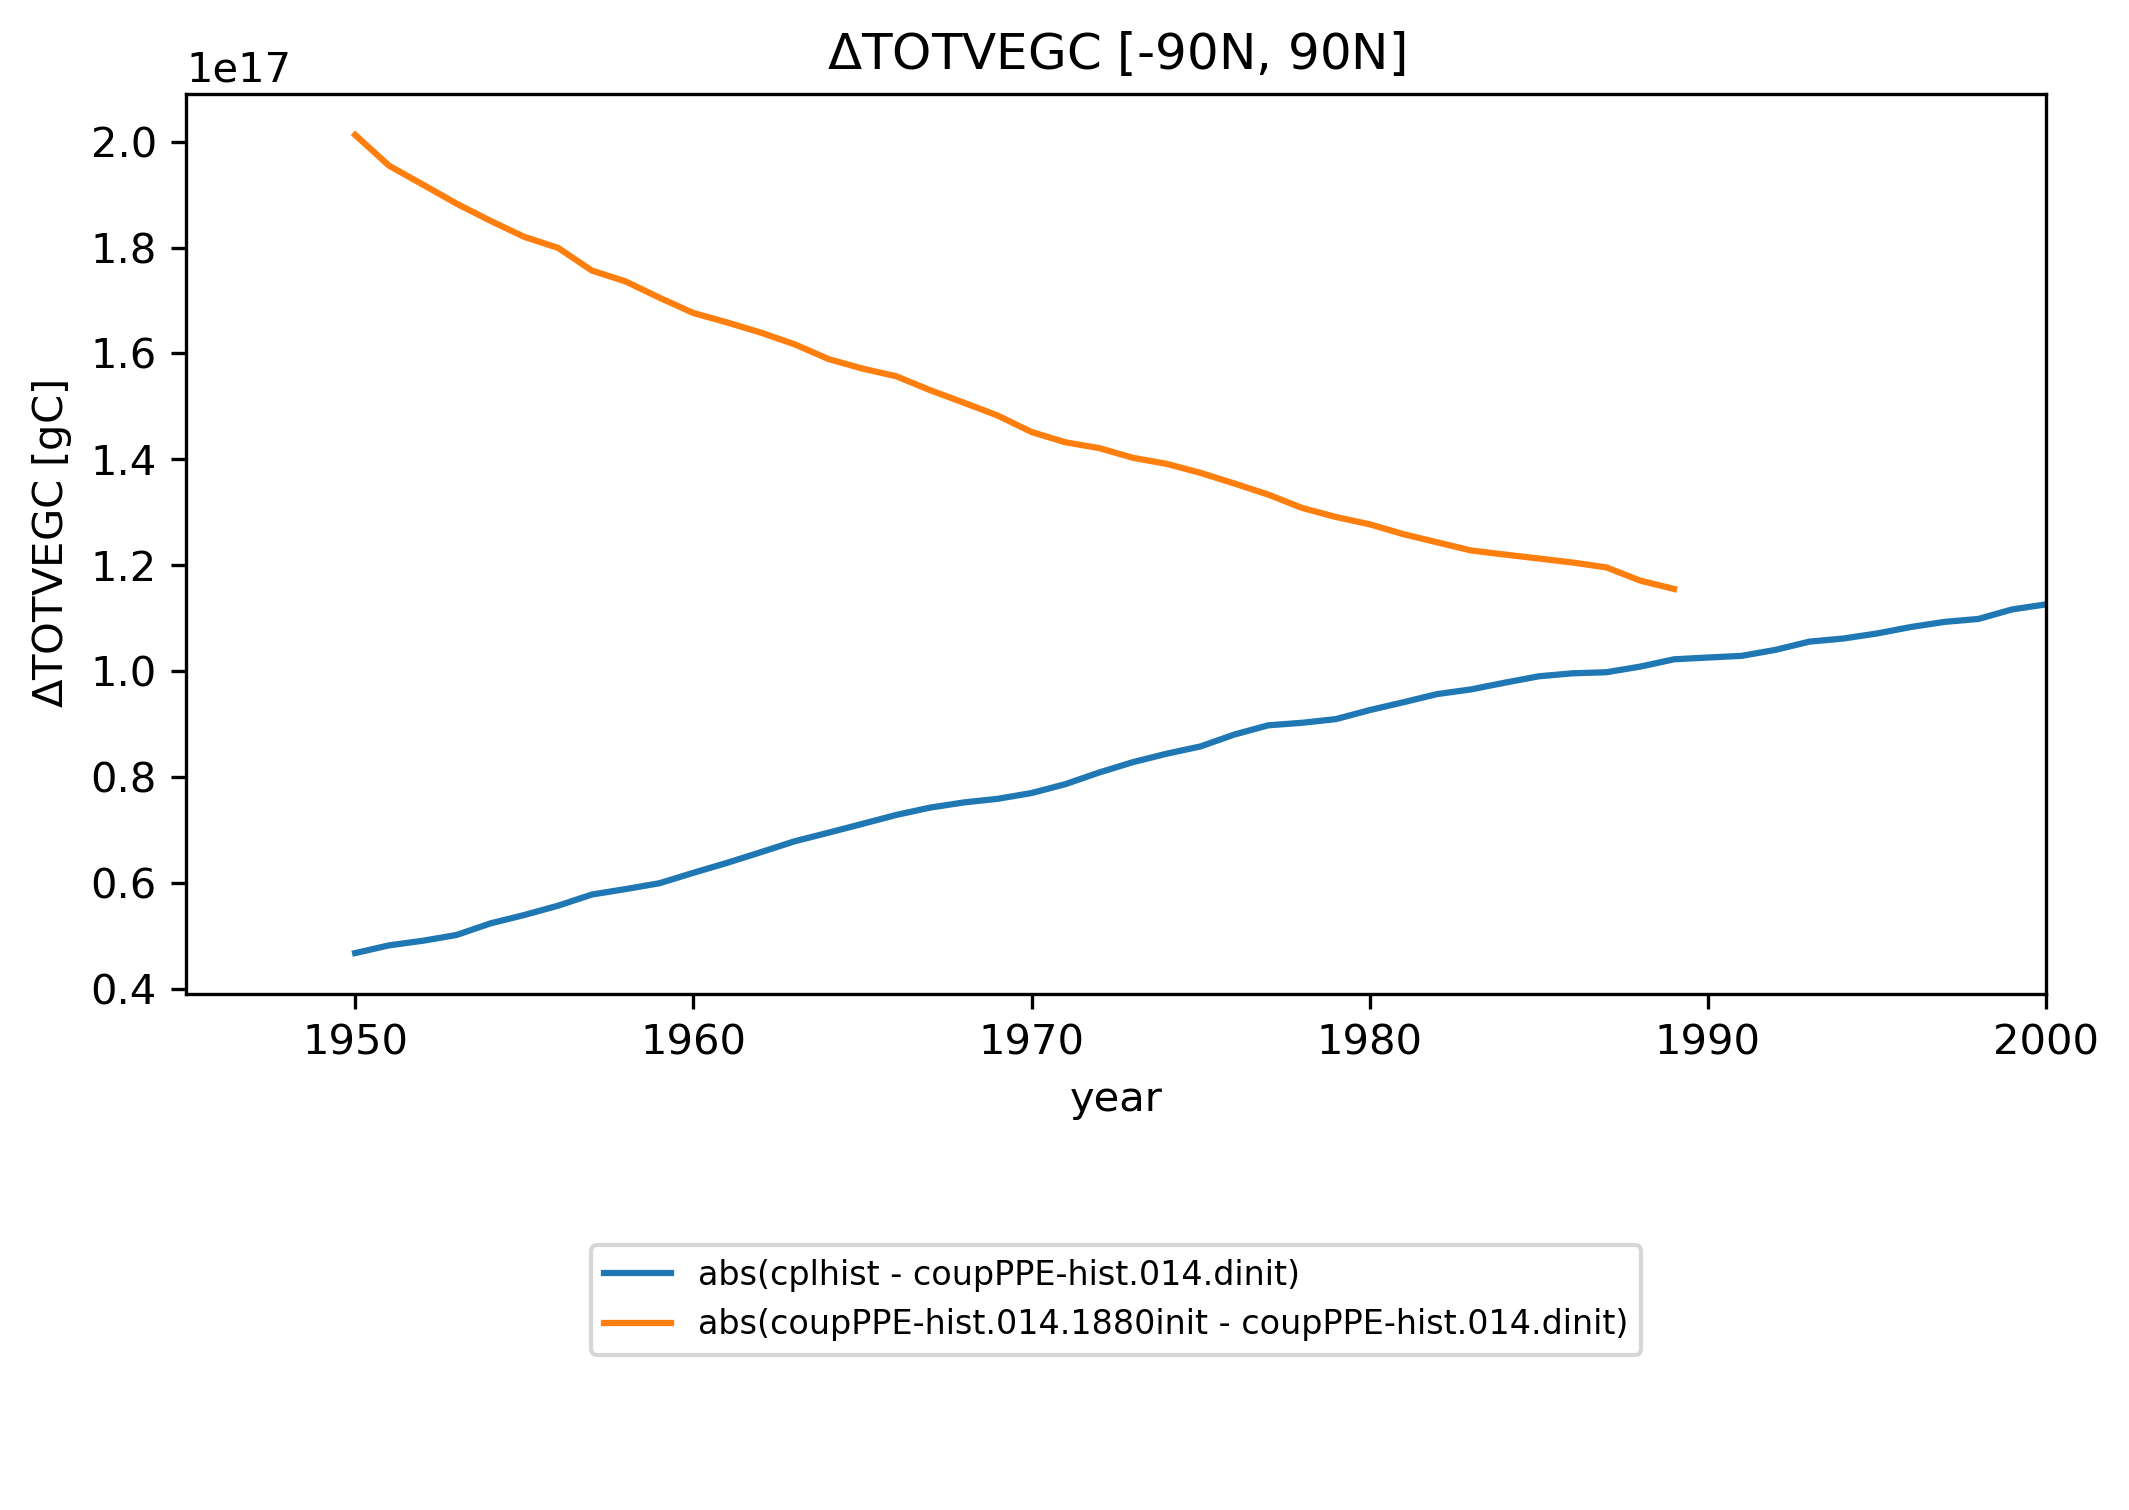

In [29]:
fig, ax = plt.subplots(2, 1, height_ratios=[1, 0.4], figsize=(8, 6), dpi=300)
srtyr = 1945
endyr = 2000

lat_1 = -90
lat_2 = 90

delta_a_b = (abs(totvegc["cplhist"].sel(lat=slice(lat_1, lat_2), time=slice(f"{srtyr}-01", f"{endyr}-12")) - totvegc["coupPPE-hist.014.dinit"].sel(lat=slice(lat_1, lat_2), time=slice(f"{srtyr}-01", f"{endyr}-12"))) * landarea).sum(dim=["lat", "lon"]).groupby("time.year").mean(dim="time").plot(ax=ax[0], color="tab:blue", label="abs(cplhist - coupPPE-hist.014.dinit)")
delta_b_c = (abs(totvegc["coupPPE-hist.014.1880init"].sel(lat=slice(lat_1, lat_2), time=slice(f"{srtyr}-01", f"{endyr}-12")) - totvegc["coupPPE-hist.014.dinit"].sel(lat=slice(lat_1, lat_2), time=slice(f"{srtyr}-01", f"{endyr}-12"))) * landarea).sum(dim=["lat", "lon"]).groupby("time.year").mean(dim="time").plot(ax=ax[0], color="tab:orange", label="abs(coupPPE-hist.014.1880init - coupPPE-hist.014.dinit)")

ax[0].set_xlim(srtyr, endyr)
ax[0].set_ylabel("$\\Delta$TOTVEGC [gC]")
ax[0].set_title(f"$\\Delta$TOTVEGC [{lat_1}N, {lat_2}N]")

h, l = ax[0].get_legend_handles_labels()
leg = ax[1].legend(h, l, fontsize=8, loc='center')
ax[1].axis('off')

<Figure size 640x480 with 0 Axes>

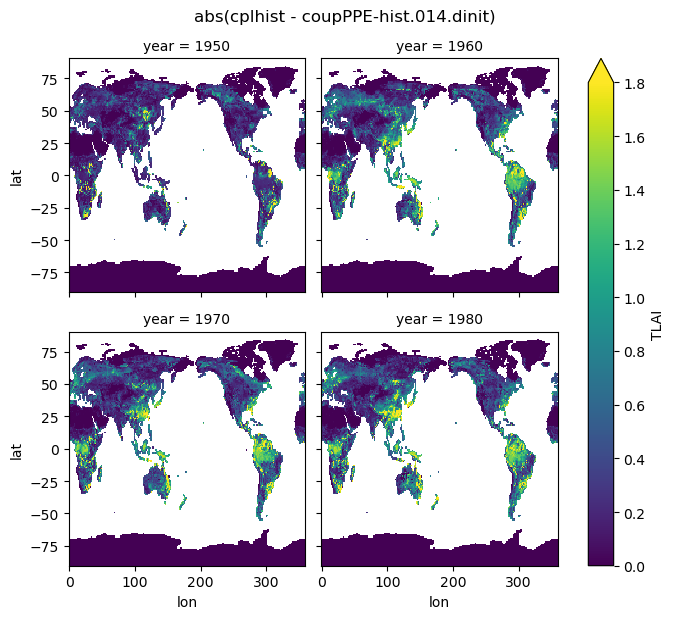

<Figure size 640x480 with 0 Axes>

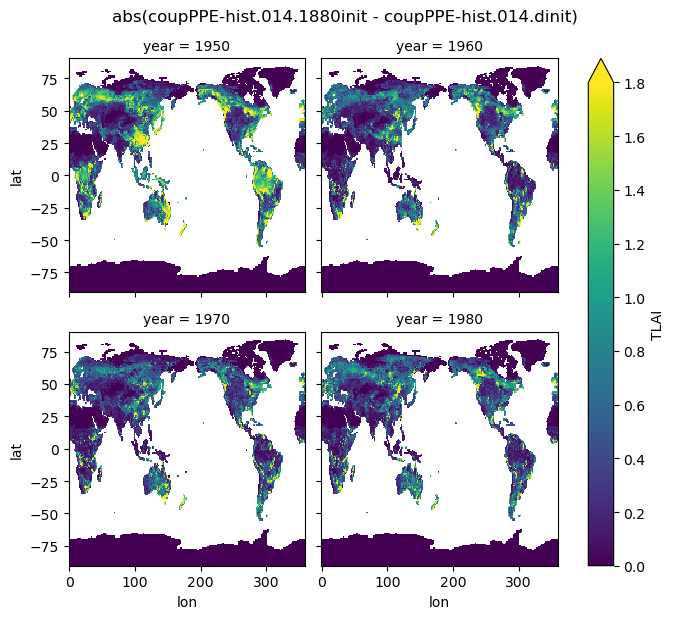

In [34]:
srtyr = 1950
endyr = 1980

lat_1 = -90
lat_2 = 90

delta_a_b = abs(tlai["cplhist"].sel(lat=slice(lat_1, lat_2), time=slice(f"{srtyr}-01", f"{endyr}-12")) - tlai["coupPPE-hist.014.dinit"].sel(lat=slice(lat_1, lat_2), time=slice(f"{srtyr}-01", f"{endyr}-12"))).groupby("time.year").mean(dim="time")
delta_b_c = abs(tlai["coupPPE-hist.014.1880init"].sel(lat=slice(lat_1, lat_2), time=slice(f"{srtyr}-01", f"{endyr}-12")) - tlai["coupPPE-hist.014.dinit"].sel(lat=slice(lat_1, lat_2), time=slice(f"{srtyr}-01", f"{endyr}-12"))).groupby("time.year").mean(dim="time")

plt.figure()
delta_a_b[::10].plot(col="year", col_wrap=2, vmin=0, vmax=1.8)
plt.suptitle("abs(cplhist - coupPPE-hist.014.dinit)", y=1.025)
plt.show()

plt.figure()
delta_b_c[::10].plot(col="year", col_wrap=2, vmin=0, vmax=1.8)
plt.suptitle("abs(coupPPE-hist.014.1880init - coupPPE-hist.014.dinit)", y=1.025)
plt.show()

<Figure size 640x480 with 0 Axes>

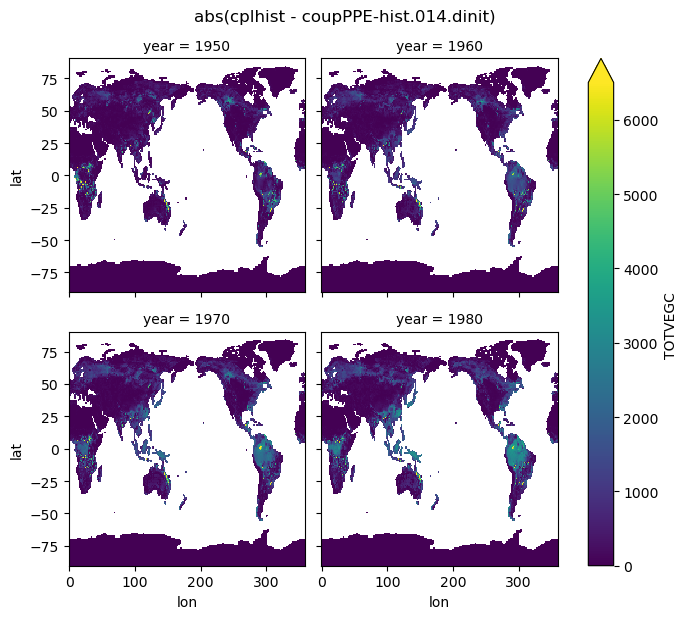

<Figure size 640x480 with 0 Axes>

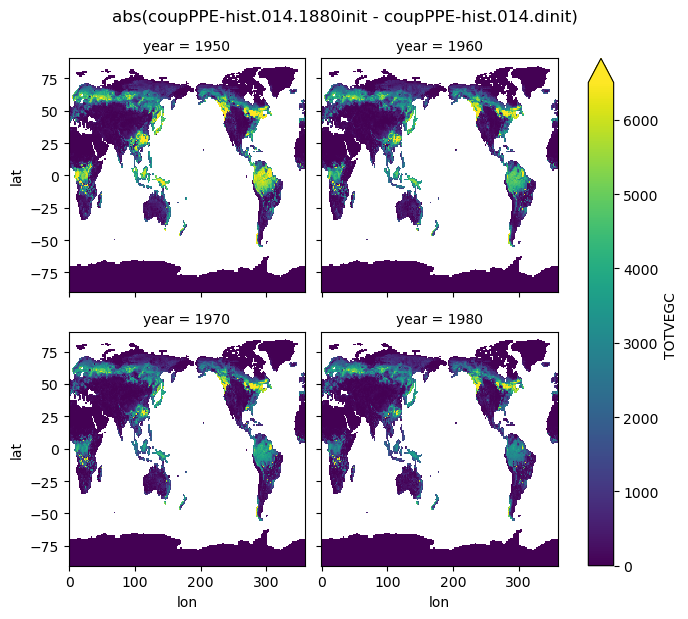

In [35]:
srtyr = 1950
endyr = 1980

lat_1 = -90
lat_2 = 90

delta_a_b = abs(totvegc["cplhist"].sel(lat=slice(lat_1, lat_2), time=slice(f"{srtyr}-01", f"{endyr}-12")) - totvegc["coupPPE-hist.014.dinit"].sel(lat=slice(lat_1, lat_2), time=slice(f"{srtyr}-01", f"{endyr}-12"))).groupby("time.year").mean(dim="time")
delta_b_c = abs(totvegc["coupPPE-hist.014.1880init"].sel(lat=slice(lat_1, lat_2), time=slice(f"{srtyr}-01", f"{endyr}-12")) - totvegc["coupPPE-hist.014.dinit"].sel(lat=slice(lat_1, lat_2), time=slice(f"{srtyr}-01", f"{endyr}-12"))).groupby("time.year").mean(dim="time")

plt.figure()
delta_a_b[::10].plot(col="year", col_wrap=2, vmin=0, vmax=6500)
plt.suptitle("abs(cplhist - coupPPE-hist.014.dinit)", y=1.025)
plt.show()

plt.figure()
delta_b_c[::10].plot(col="year", col_wrap=2, vmin=0, vmax=6500)
plt.suptitle("abs(coupPPE-hist.014.1880init - coupPPE-hist.014.dinit)", y=1.025)
plt.show()

<Figure size 640x480 with 0 Axes>

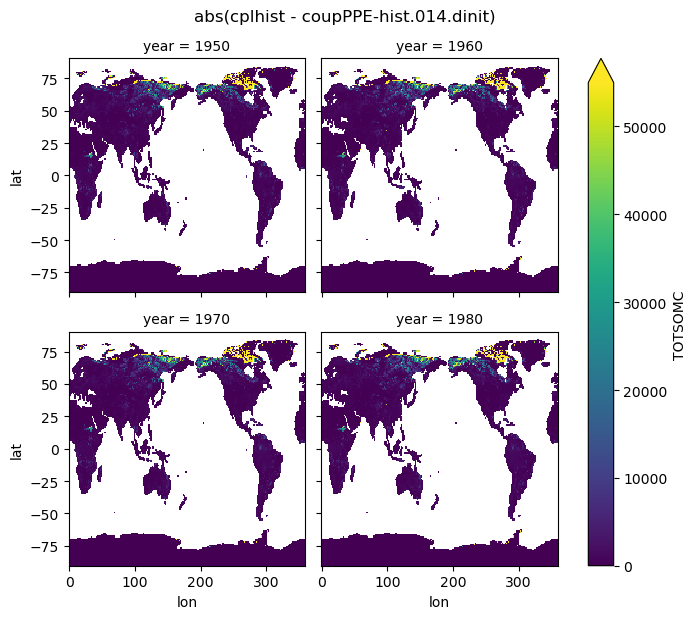

<Figure size 640x480 with 0 Axes>

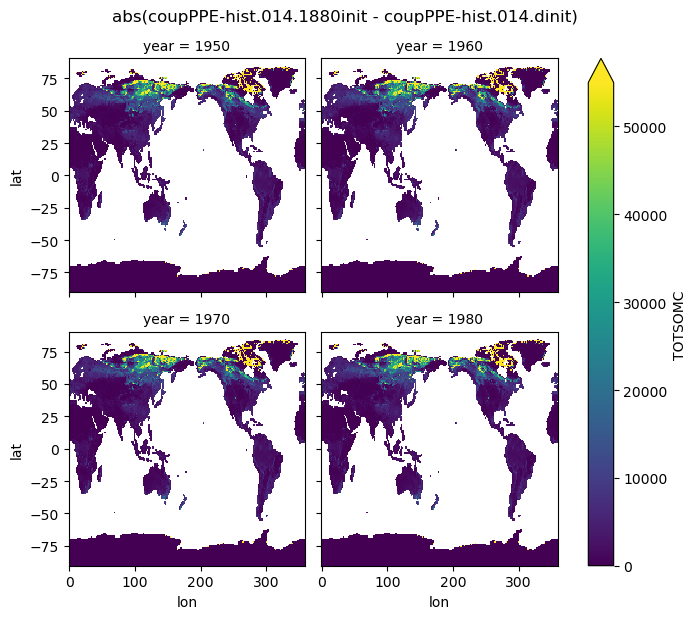

In [37]:
srtyr = 1950
endyr = 1980

lat_1 = -90
lat_2 = 90

delta_a_b = abs(totsomc["cplhist"].sel(lat=slice(lat_1, lat_2), time=slice(f"{srtyr}-01", f"{endyr}-12")) - totsomc["coupPPE-hist.014.dinit"].sel(lat=slice(lat_1, lat_2), time=slice(f"{srtyr}-01", f"{endyr}-12"))).groupby("time.year").mean(dim="time")
delta_b_c = abs(totsomc["coupPPE-hist.014.1880init"].sel(lat=slice(lat_1, lat_2), time=slice(f"{srtyr}-01", f"{endyr}-12")) - totsomc["coupPPE-hist.014.dinit"].sel(lat=slice(lat_1, lat_2), time=slice(f"{srtyr}-01", f"{endyr}-12"))).groupby("time.year").mean(dim="time")

plt.figure()
delta_a_b[::10].plot(col="year", col_wrap=2, vmin=0, vmax=55000)
plt.suptitle("abs(cplhist - coupPPE-hist.014.dinit)", y=1.025)
plt.show()

plt.figure()
delta_b_c[::10].plot(col="year", col_wrap=2, vmin=0, vmax=55000)
plt.suptitle("abs(coupPPE-hist.014.1880init - coupPPE-hist.014.dinit)", y=1.025)
plt.show()

In [ ]:
client.shutdown()
!rm ./dask-worker.e*
!rm ./dask-worker.o*